In [ ]:
library(Seurat)
library(ggplot2)
library(dplyr)
library(patchwork)
library(stringr)
library(ggplot2)

In [ ]:
## https://drive.google.com/file/d/16Jq6w_KAWwI2rBN7SYBw-7bm5qwVoFyt/view?usp=drive_link
seu_obj <- readRDS(file="/project/zhuzhuzhang/lyang/scaleBio_RNA_rat_brain/out_mRatBN/merged_seurat_obj_celltype_annotated_2.rds")

## https://drive.google.com/file/d/1Q7HV0PAfjac-19xNM455wGNN6zvkOyx4/view?usp=drive_link
pseudo_seu <- readRDS(file = "./pseudo_Seu_obj_2.rds")

## https://drive.google.com/file/d/1XbDy0A_rLt-kTDQvtqyCCGJ__qxdym7e/view?usp=drive_link
pseudo_de <- readRDS(file = "./pseudo_DESeq2_DEG_2.rds")

In [75]:
Idents(seu_obj) <- "celltype"
gene_ls <- c("Slc17a7", ## Exc
             "Prex1","Enpp2","Rfx3", ## L2/3 IT
             "Rorb", "Kcnh5","Cadps2", ## L4 IT
             "Ptgfran","Il1rapl2", ## L5 IT
             "Mgat","Rspo2","Kcnab1", ## L6 IT
             "Vwc2l","Nxph1",## L5/6 NP
             "Foxp2","Tle4","Syt6", ## L6 CT
             "Vat1l","Etv1","Tcerg1l", ## L5 ET
             "Fgf13","Lamp5","Vip", "Npas3",## CGE-Inh
             "Sst", "Grin3a", ## Sst-Inh
             "Cemip","Man1c1", ## Pvalb-Inh
             "Slc1a3","Atp1a2", ## ASC
            "Mbp","Mobp","Plp1",## ODC
             "Gfra1","Shisa6", ## OPC
             "Flt1","Cyyr1", ## Endo
             "Pbx3","Rgs9" ## STR
             
            )
data_df <- cbind(sample_name=colnames(seu_obj@assays$SCT$data),
      as.data.frame(t(as.matrix(seu_obj@assays$SCT$data[gene_ls[gene_ls %in% row.names(seu_obj@assays$SCT$data)],]))))
anno <- seu_obj@meta.data %>%
        mutate(sample_name=row.names(.)) %>%
        mutate(celltype_id=celltype) %>%
        mutate(celltype_label=celltype)

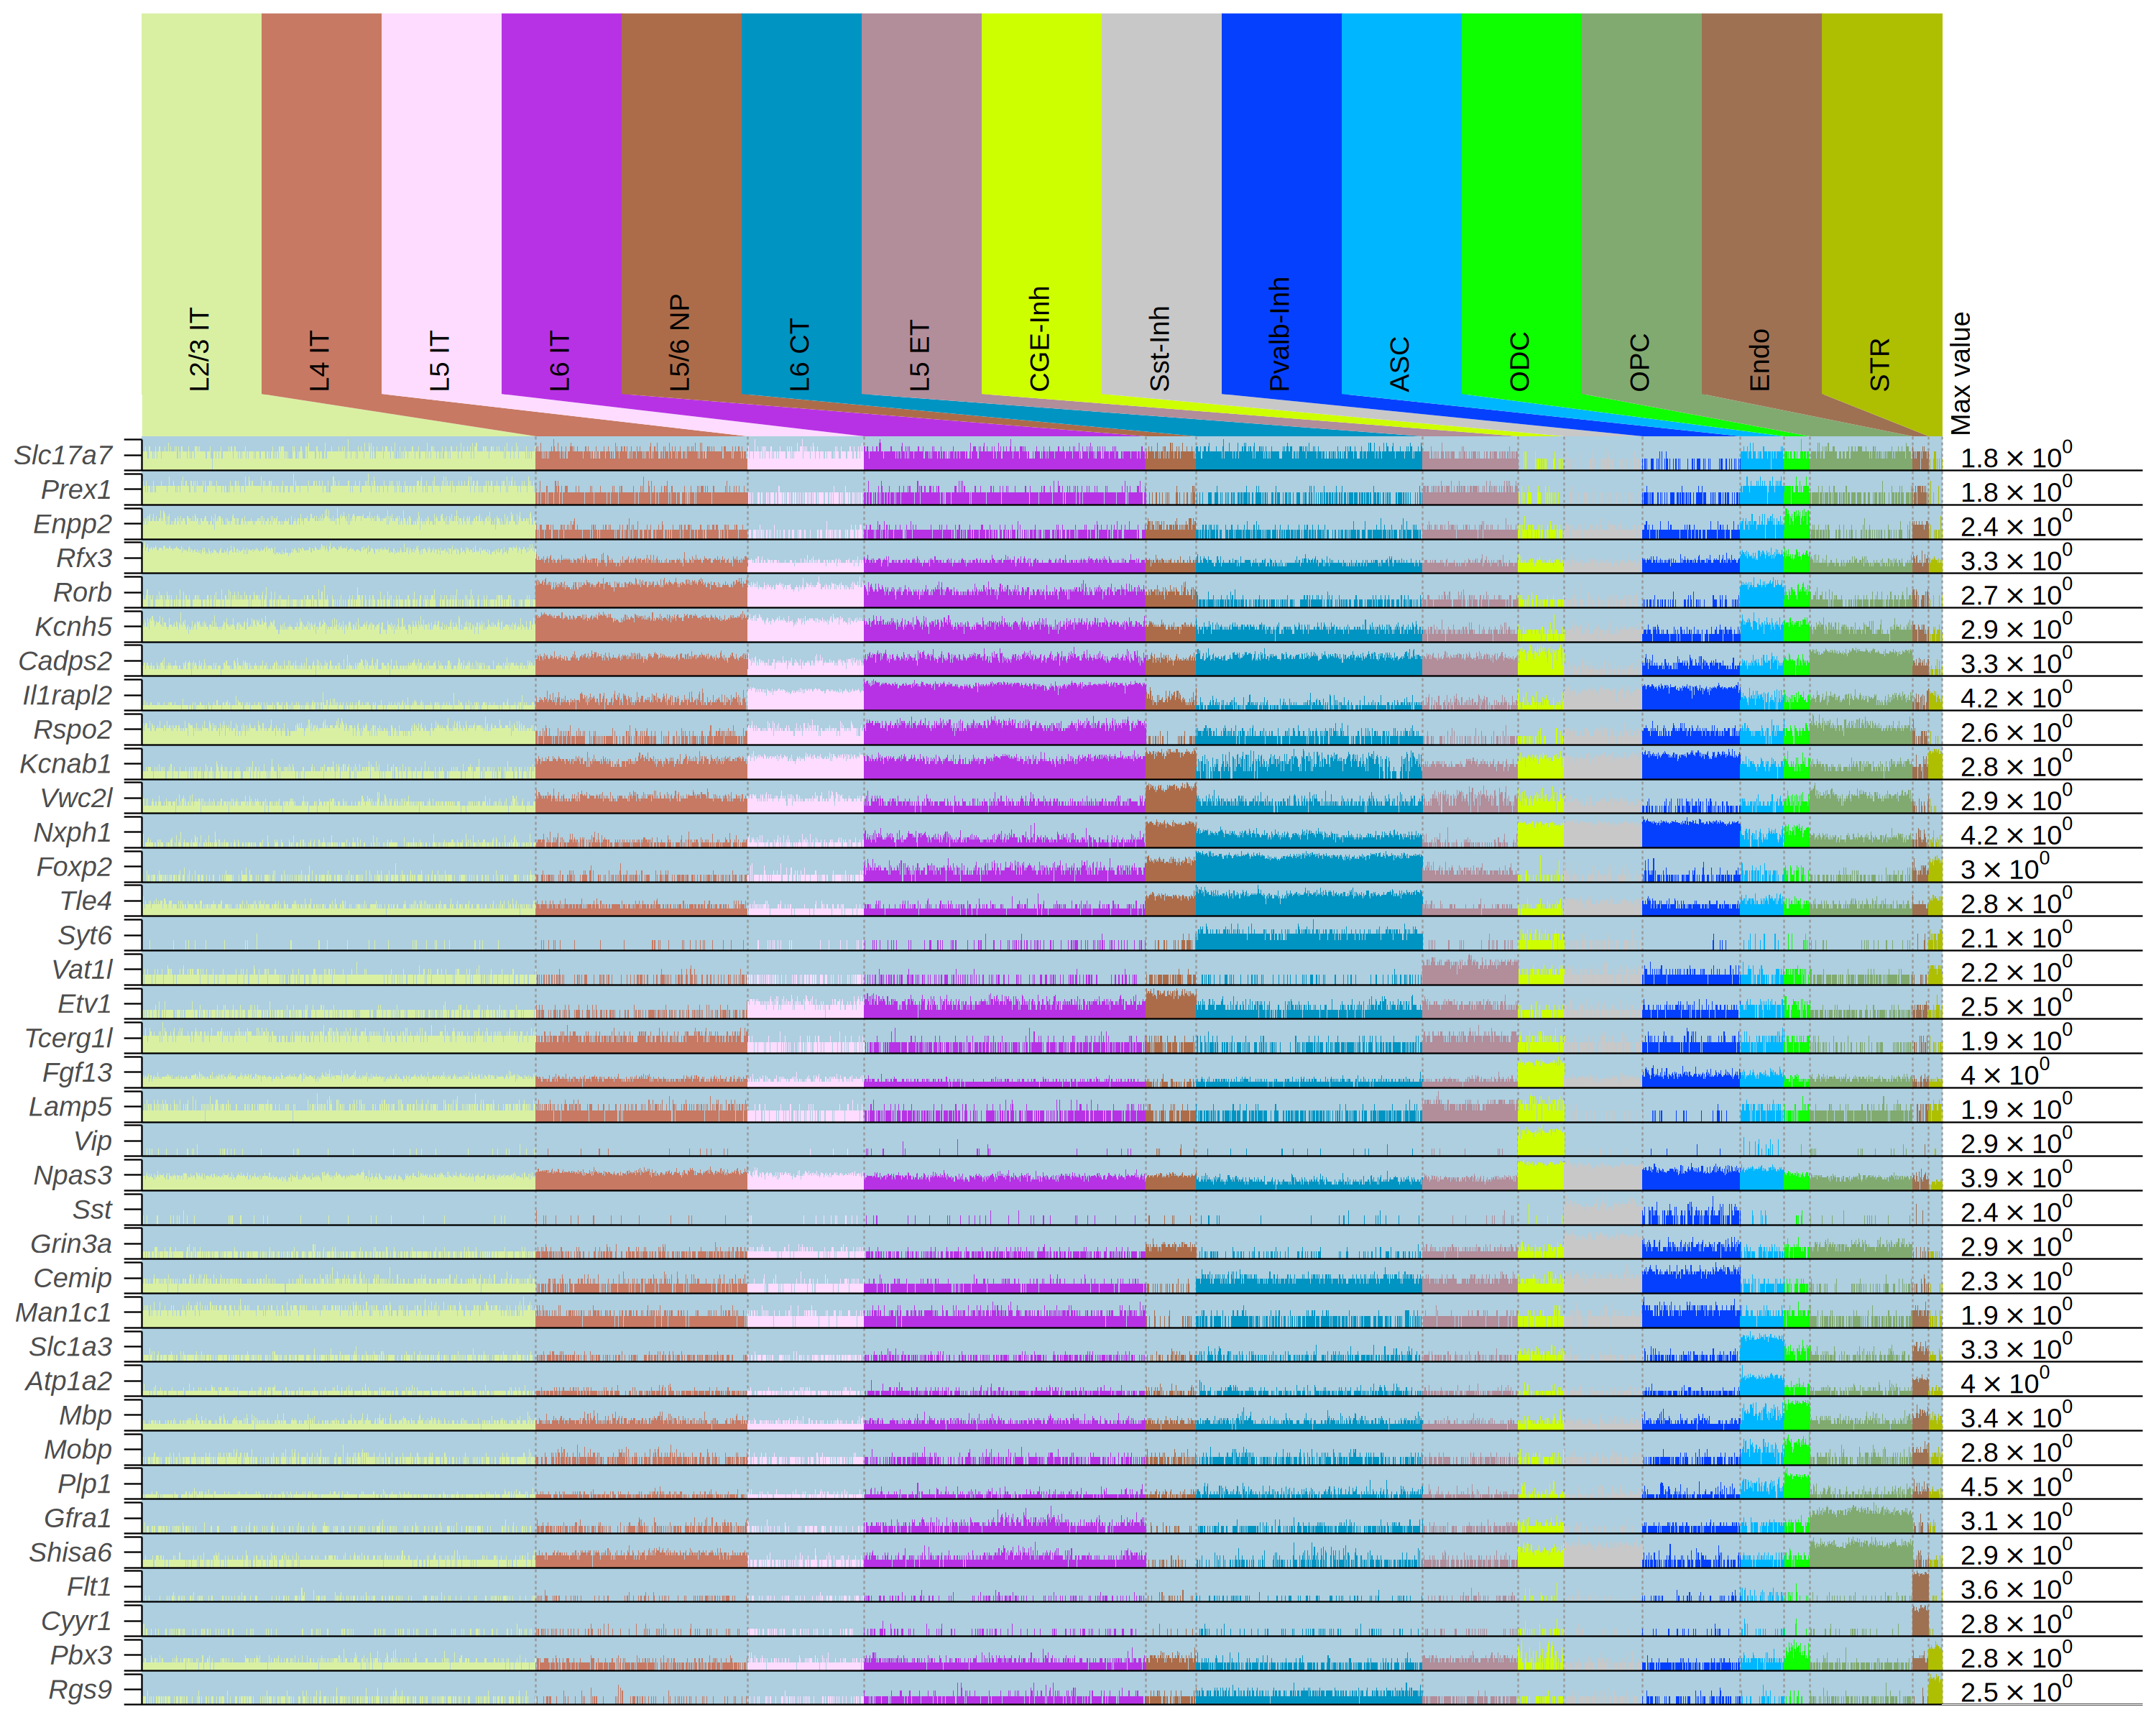

In [77]:
options(repr.plot.width = 10, repr.plot.height = 8, repr.plot.res = 300)
p <- sample_bar_plot(data_df, 
                anno, 
                genes = gene_ls[gene_ls %in% row.names(seu_obj@assays$SCT$data)], 
                grouping = "celltype", 
                log_scale = FALSE,
                font_size = 9,
                label_type = "angle")
print(p)

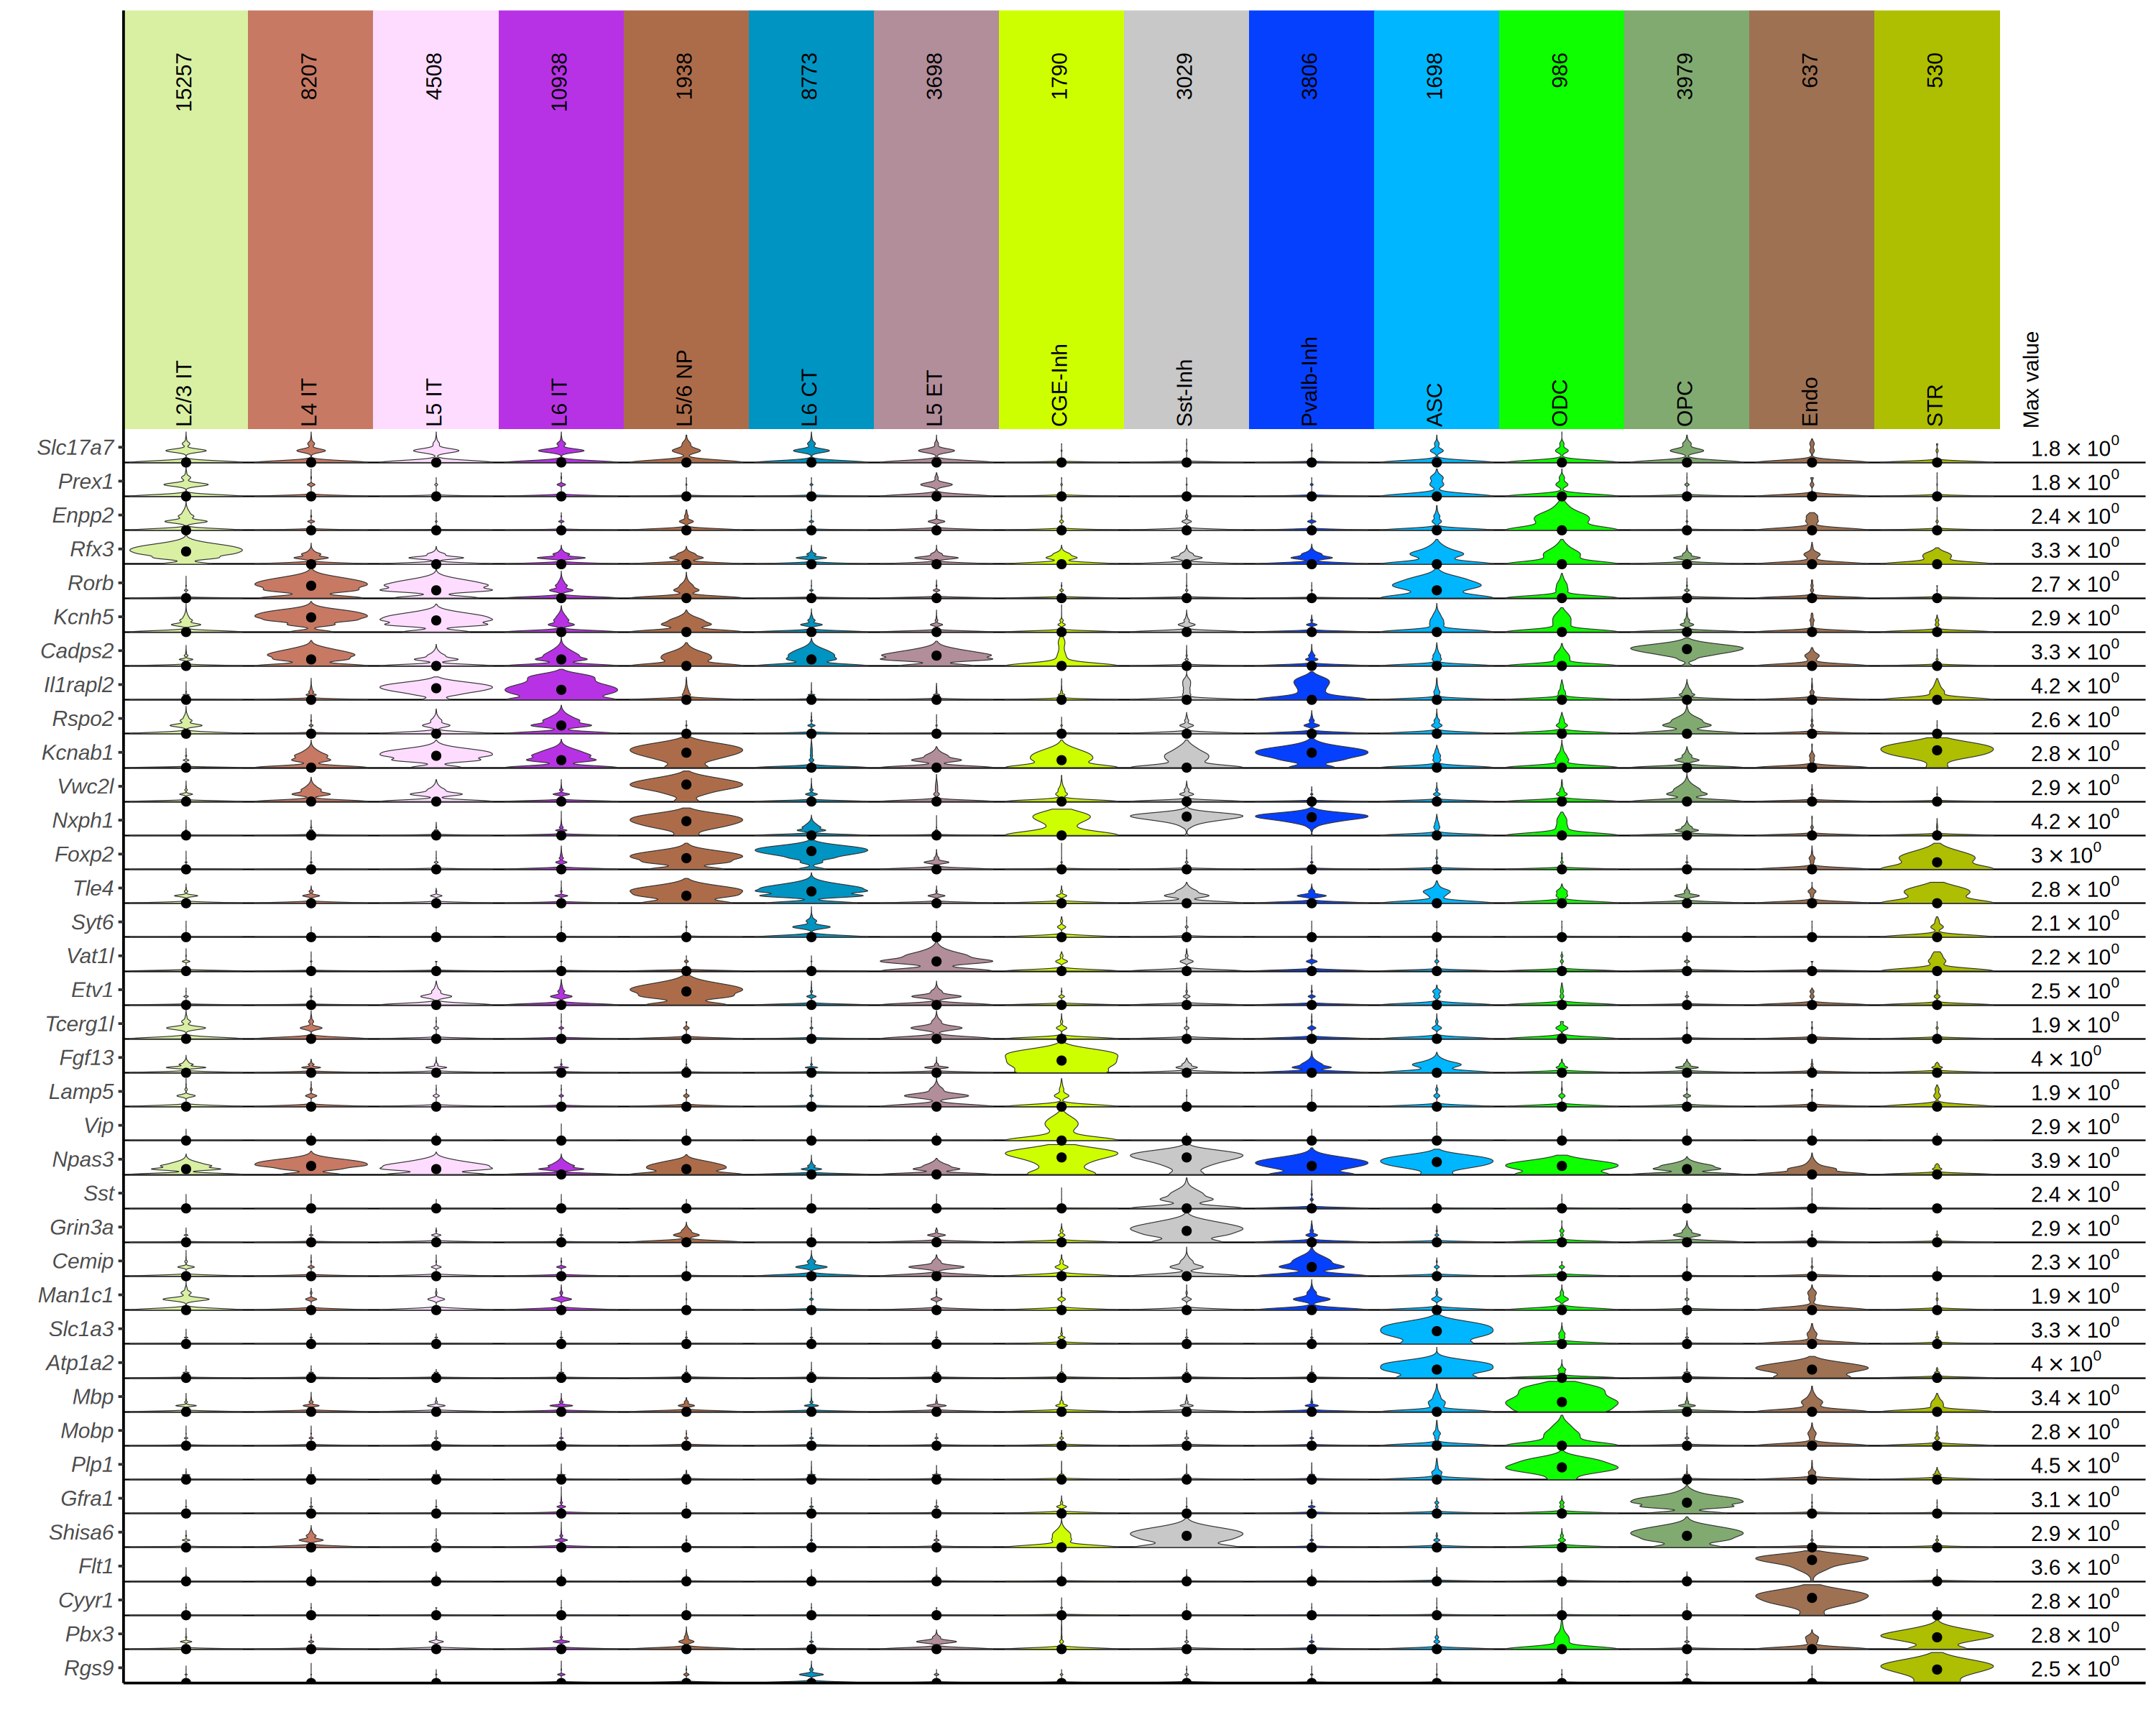

In [78]:
group_violin_plot(data_df, 
                  anno, 
                  genes = gene_ls[gene_ls %in% row.names(seu_obj@assays$SCT$data)], 
                  grouping = "celltype", 
                  log_scale = FALSE,
                  font_size = 7,
                  rotate_counts = TRUE)

## check expression on DEGs

In [73]:
head(pseudo_seu)

orig.ident        sample_name celltype  celltype.group
iso-F-1_L2/3 IT   iso-F-1_L2/3 IT   iso-F-1     L2/3 IT   L2/3 IT_iso   
iso-F-1_L4 IT     iso-F-1_L4 IT     iso-F-1     L4 IT     L4 IT_iso     
iso-F-1_L5 IT     iso-F-1_L5 IT     iso-F-1     L5 IT     L5 IT_iso     
iso-F-1_L6 IT     iso-F-1_L6 IT     iso-F-1     L6 IT     L6 IT_iso     
iso-F-1_L5/6 NP   iso-F-1_L5/6 NP   iso-F-1     L5/6 NP   L5/6 NP_iso   
iso-F-1_L6 CT     iso-F-1_L6 CT     iso-F-1     L6 CT     L6 CT_iso     
iso-F-1_L5 ET     iso-F-1_L5 ET     iso-F-1     L5 ET     L5 ET_iso     
iso-F-1_CGE-Inh   iso-F-1_CGE-Inh   iso-F-1     CGE-Inh   CGE-Inh_iso   
iso-F-1_Sst-Inh   iso-F-1_Sst-Inh   iso-F-1     Sst-Inh   Sst-Inh_iso   
iso-F-1_Pvalb-Inh iso-F-1_Pvalb-Inh iso-F-1     Pvalb-Inh Pvalb-Inh_iso

In [143]:
pseudo_de <- pseudo_de[-16]

In [12]:
library(tidyr)
library(ComplexHeatmap)
library(tibble)
library(circlize)

Loading required package: grid

ComplexHeatmap version 2.18.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite either one:
- Gu, Z. Complex Heatmap Visualization. iMeta 2022.
- Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
    genomic data. Bioinformatics 2016.


The new InteractiveComplexHeatmap package can directly export static 
complex heatmaps into an interactive Shiny app with zero effort. Have a try!

This message can be suppressed by:
  suppressPackageStartupMessages(library(ComplexHeatmap))


circlize version 0.4.16
CRAN page: https://cran.r-project.org/package=circlize
Github page: https://github.com/jokergoo/circlize
Documentation: https://jokergoo.github.io/circlize_book/book/

If you use it in published research, please cite:
Gu, Z. circlize implements a

## merge the DEG list

In [6]:
DEG_ls<-
lapply(seq_len(length(names(pseudo_de))), function(x) {
    if (sum(pseudo_de[[x]]$p_val_adj < 0.05 & abs(pseudo_de[[x]]$avg_log2FC) > 0.3,na.rm = TRUE) > 0) {
        pseudo_de[[x]] %>%
            filter(p_val_adj < 0.05, abs(avg_log2FC) > 0.3)
    }
})
names(DEG_ls) <- names(pseudo_de)
DEG_ls <- DEG_ls[!sapply(DEG_ls,is.null)]

In [9]:
DEG_merged<- do.call(rbind,Map(cbind, DEG_ls, new_clumn = names(DEG_ls))) %>%
  mutate(gene = str_split(row.names(.), "\\.", simplify = TRUE)[, 2]) %>%
    filter(gene != "")

In [10]:
DEG_merged[1:3,]

p_val        avg_log2FC pct.1 pct.2 p_val_adj    new_clumn
L2/3 IT.LOC102548918 2.089267e-15 -1.3097989 1     1     5.556822e-11 L2/3 IT  
L2/3 IT.Iqgap2       1.322525e-12 -0.7579870 1     1     3.517520e-08 L2/3 IT  
L2/3 IT.Pdzd2        2.604076e-12 -0.8742842 1     1     6.926060e-08 L2/3 IT  
                     gene        
L2/3 IT.LOC102548918 LOC102548918
L2/3 IT.Iqgap2       Iqgap2      
L2/3 IT.Pdzd2        Pdzd2

In [130]:
DEG_up_ls<-
lapply(seq_len(length(names(pseudo_de))), function(x) {
    if (sum(pseudo_de[[x]]$p_val_adj < 0.05 & pseudo_de[[x]]$avg_log2FC > 0.3,na.rm = TRUE) > 0) {
        pseudo_de[[x]] %>%
            filter(p_val_adj < 0.05, avg_log2FC > 0.3)
    }
})
names(DEG_up_ls) <- names(pseudo_de)
DEG_up_ls <- DEG_up_ls[!sapply(DEG_up_ls,is.null)]

In [88]:
DEG_down_ls<-
lapply(seq_len(length(names(pseudo_de))), function(x) {
    if (sum(pseudo_de[[x]]$p_val_adj < 0.05 & pseudo_de[[x]]$avg_log2FC < (-0.3),na.rm = TRUE) > 0) {
        pseudo_de[[x]] %>%
            filter(p_val_adj < 0.05, avg_log2FC < (-0.3))
    }
})
names(DEG_down_ls) <- names(pseudo_de)
DEG_down_ls <- DEG_down_ls[!sapply(DEG_down_ls,is.null)]

In [89]:
names(DEG_down_ls)

[1] "L2/3 IT" "L4 IT"   "L5 IT"   "L6 IT"   "L6 CT"   "L5 ET"   "CGE-Inh"
[8] "OPC"

## save the FC data for all celltypes for all DEGs

In [15]:
## gather fold change information together
DEG_ls<- 
lapply(seq_len(length(names(pseudo_de))), function(x) {
        pseudo_de[[x]] %>%
            filter(row.names(.) %in% unique(isoVSsoc_DEG_ls$gene))
    })
names(DEG_ls) <- names(pseudo_de)
all_DEG_gene <- do.call(rbind,Map(cbind, DEG_ls, new_clumn = names(DEG_ls))) %>%
  mutate(gene = str_split(row.names(.), "\\.", simplify = TRUE)[, 2]) %>%
    filter(gene != "")

all_DEG_gene %>%
    select(new_clumn,avg_log2FC,gene) %>%
    tidyr::pivot_wider(names_from = new_clumn, values_from = avg_log2FC) %>%
    tibble::column_to_rownames(var="gene") %>%
    write.table(file="./isoVSsoc_DEG_FC_celltype_matrix.tsv",quote=F,sep="\t",row.names=T)

all_DEG_gene %>%
    select(new_clumn,p_val_adj,gene) %>%
    tidyr::pivot_wider(names_from = new_clumn, values_from = p_val_adj) %>%
    tibble::column_to_rownames(var="gene") %>%
    write.table(file="./isoVSsoc_DEG_adjP_celltype_matrix.tsv",quote=F,sep="\t",row.names=T)

### make heatmap for all FCs in all celltypes

In [8]:
isoVSsoc_DEG_FC <- read.table("./isoVSsoc_DEG_FC_celltype_matrix.tsv", header=T,sep="\t",row.names=1)
isoVSsoc_DEG_P <- read.table("./isoVSsoc_DEG_adjP_celltype_matrix.tsv", header=T,sep="\t",row.names=1)

In [9]:
rm.neg<-plyr::colwise(function(x){
  return(ifelse(x < 0.0001,"****", 
                ifelse(x<0.001,"***",
                      ifelse(x<0.01,"**",
                            ifelse(x<0.05,"*","")))))})
p_sign_df <- rm.neg(isoVSsoc_DEG_P)

row.names(p_sign_df) <- row.names(isoVSsoc_DEG_P)
colnames(p_sign_df) <- c("L2/3 IT", "L4 IT", "L5 IT", "L6 IT", "L5/6 NP", "L6 CT", "L5 ET", "CGE-Inh", "Sst-Inh", "Pvalb-Inh", "ASC", "ODC", "OPC", "Endo")

colnames(isoVSsoc_DEG_FC) <- c("L2/3 IT", "L4 IT", "L5 IT", "L6 IT", "L5/6 NP", "L6 CT", "L5 ET", "CGE-Inh", "Sst-Inh", "Pvalb-Inh", "ASC", "ODC", "OPC", "Endo")
p_sign_df[is.na(p_sign_df)] <- ""
p_sign_df[abs(isoVSsoc_DEG_FC)<0.3] <- ""

In [10]:
summary(isoVSsoc_DEG_FC)

    L2/3 IT             L4 IT              L5 IT             L6 IT          
 Min.   :-1.30980   Min.   :-1.09734   Min.   :-0.8480   Min.   :-1.111527  
 1st Qu.:-0.63743   1st Qu.:-0.38195   1st Qu.:-0.2615   1st Qu.:-0.569098  
 Median :-0.51781   Median :-0.17385   Median :-0.1304   Median :-0.424604  
 Mean   :-0.34255   Mean   :-0.08588   Mean   :-0.0397   Mean   :-0.336213  
 3rd Qu.: 0.07853   3rd Qu.: 0.21437   3rd Qu.: 0.2450   3rd Qu.:-0.007744  
 Max.   : 0.79294   Max.   : 0.86125   Max.   : 0.8612   Max.   : 0.451747  
    L5/6 NP             L6 CT             L5 ET             CGE-Inh       
 Min.   :-1.00000   Min.   :-1.1010   Min.   :-0.82254   Min.   :-0.7605  
 1st Qu.:-0.43982   1st Qu.:-0.6284   1st Qu.:-0.49044   1st Qu.:-0.4358  
 Median :-0.25787   Median :-0.4191   Median :-0.25448   Median :-0.2937  
 Mean   :-0.24905   Mean   :-0.3686   Mean   :-0.18328   Mean   :-0.2709  
 3rd Qu.:-0.08553   3rd Qu.:-0.0889   3rd Qu.: 0.08577   3rd Qu.:-0.1583  
 Max.   : 0

In [13]:
col_fun = colorRamp2(c(-1, 0, 1), c("#0077b6", "white", "#e63946"))
p = Heatmap(isoVSsoc_DEG_FC, name = "iso/soc\navg_logFC", col = col_fun,
        cluster_columns = F,
        show_row_dend = F,
        heatmap_legend_param = list(
            legend_direction = "horizontal", 
        legend_width = unit(6, "cm")),
        row_names_gp = grid::gpar(fontsize = 6),
        column_names_gp = grid::gpar(fontsize = 6),
        cell_fun = function(j, i, x, y, width, height, fill) {
            gb = textGrob("*")
        	gb_w = convertWidth(grobWidth(gb), "mm")
        	gb_h = convertHeight(grobHeight(gb), "mm")
            grid.text(sprintf("%s", p_sign_df[i, j]), x, y - gb_h*0.5 + gb_w*0.4, gp = gpar(fontsize = 10))
})

lgd1 = Legend(labels=c("<0.0001","<0.001","<0.01","<0.05"),pch = c("**** ","*** ","** ","* "), title = "adj.p", type = "points", 
    background = "white",direction = "horizontal")
lgd2 = Legend(labels="gene not detected",legend_gp = gpar(fill = "grey"), title = "NA")

pdf("isoVSsoc_DEG_logFC_heatmap.pdf",width=5,height=7)
draw(p,annotation_legend_list = list(lgd1),heatmap_legend_side="bottom", annotation_legend_side="right",
           legend_grouping = "original")
dev.off()

Warning message:
“The input is a data frame-like object, convert it to a matrix.”


png 
  2

In [27]:
isoVSsoc_DEG_ls$P_label<- 
    symnum(isoVSsoc_DEG_ls$p_val_adj, cutpoints = c(0, 0.0001, 0.001, 0.01, 0.05,1),
       symbols = c("****", "***", "**", "*", "ns"),
       abbr.colnames = FALSE, na = "")

In [19]:
Idents(seu_obj) <- "celltype"

In [34]:
make_vlnplot <- 
function(genes=NULL,celltype=NULL,label_df=NULL){
    VlnPlot(seu_obj, 
        features = genes,
        idents=celltype,
        split.by = "group",
        pt.size = 0.0,
        #split.plot = T,
        log=FALSE)&
        scale_fill_manual(values=c("iso"="#e31a1c","soc"="#ffda79")) &
        annotate("text",x=label_df$new_clumn,y=Inf,label=label_df$P_label,vjust=1,hjust=0.5) &
        #stat_summary(fun = median, fun.min = median, fun.max = median,
        #         geom = "crossbar", 
        #         width = 0.6,
        #         position = position_dodge(width = .70)) &
                xlab("") &
                ylab("Gene Expression") &
          stat_summary(fun = "mean",
               geom = "point",
               color = "black",
               position = position_dodge(width = .90)) &
    labs(caption = paste("adj.p: ","**** <0.0001","*** <0.001","** <0.01","* <0.05")) &
    guides(fill = guide_legend(override.aes = list(linetype = 0,size = 0)),
               color = guide_legend(override.aes = list(linetype = 0,size=0)))
}

In [22]:
gene_for_plot <- read.csv("./genes_for_vlnplot.csv",header=F,sep="\t")

In [23]:
gene_for_plot

V1           V2                           
1  LOC102548918 L2/3 IT,L5 IT,L6 CT,L6 IT,OPC
2  Slit2        L2/3 IT,L4 IT,L5 IT          
3  Aff3         L2/3 IT,L5 ET,L6 CT,L6 IT    
4  Pde10a       L2/3 IT,L5 ET,L6 CT,L6 IT    
5  Dscaml1      L2/3 IT,L6 IT,OPC            
6  Samd5        L5 IT,L6 CT,L6 IT            
7  Apba2        L2/3 IT,L4 IT                
8  Grm3         L2/3 IT,L5 ET                
9  Klhl1        L2/3 IT,L5 ET                
10 Pdzd2        L2/3 IT,L5 ET                
11 Ppm1l        L2/3 IT,L5 ET                
12 Kcnd3        L2/3 IT,L6 CT                
13 Zmiz1        L2/3 IT,L6 IT                
14 Fmn1         L4 IT,L6 IT                  
15 Myt1l        L5 ET,L6 CT

In [8]:
label_df <- data.frame(celltype=c("L2/3 IT","L5 IT"),label=c("*","ns"))

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


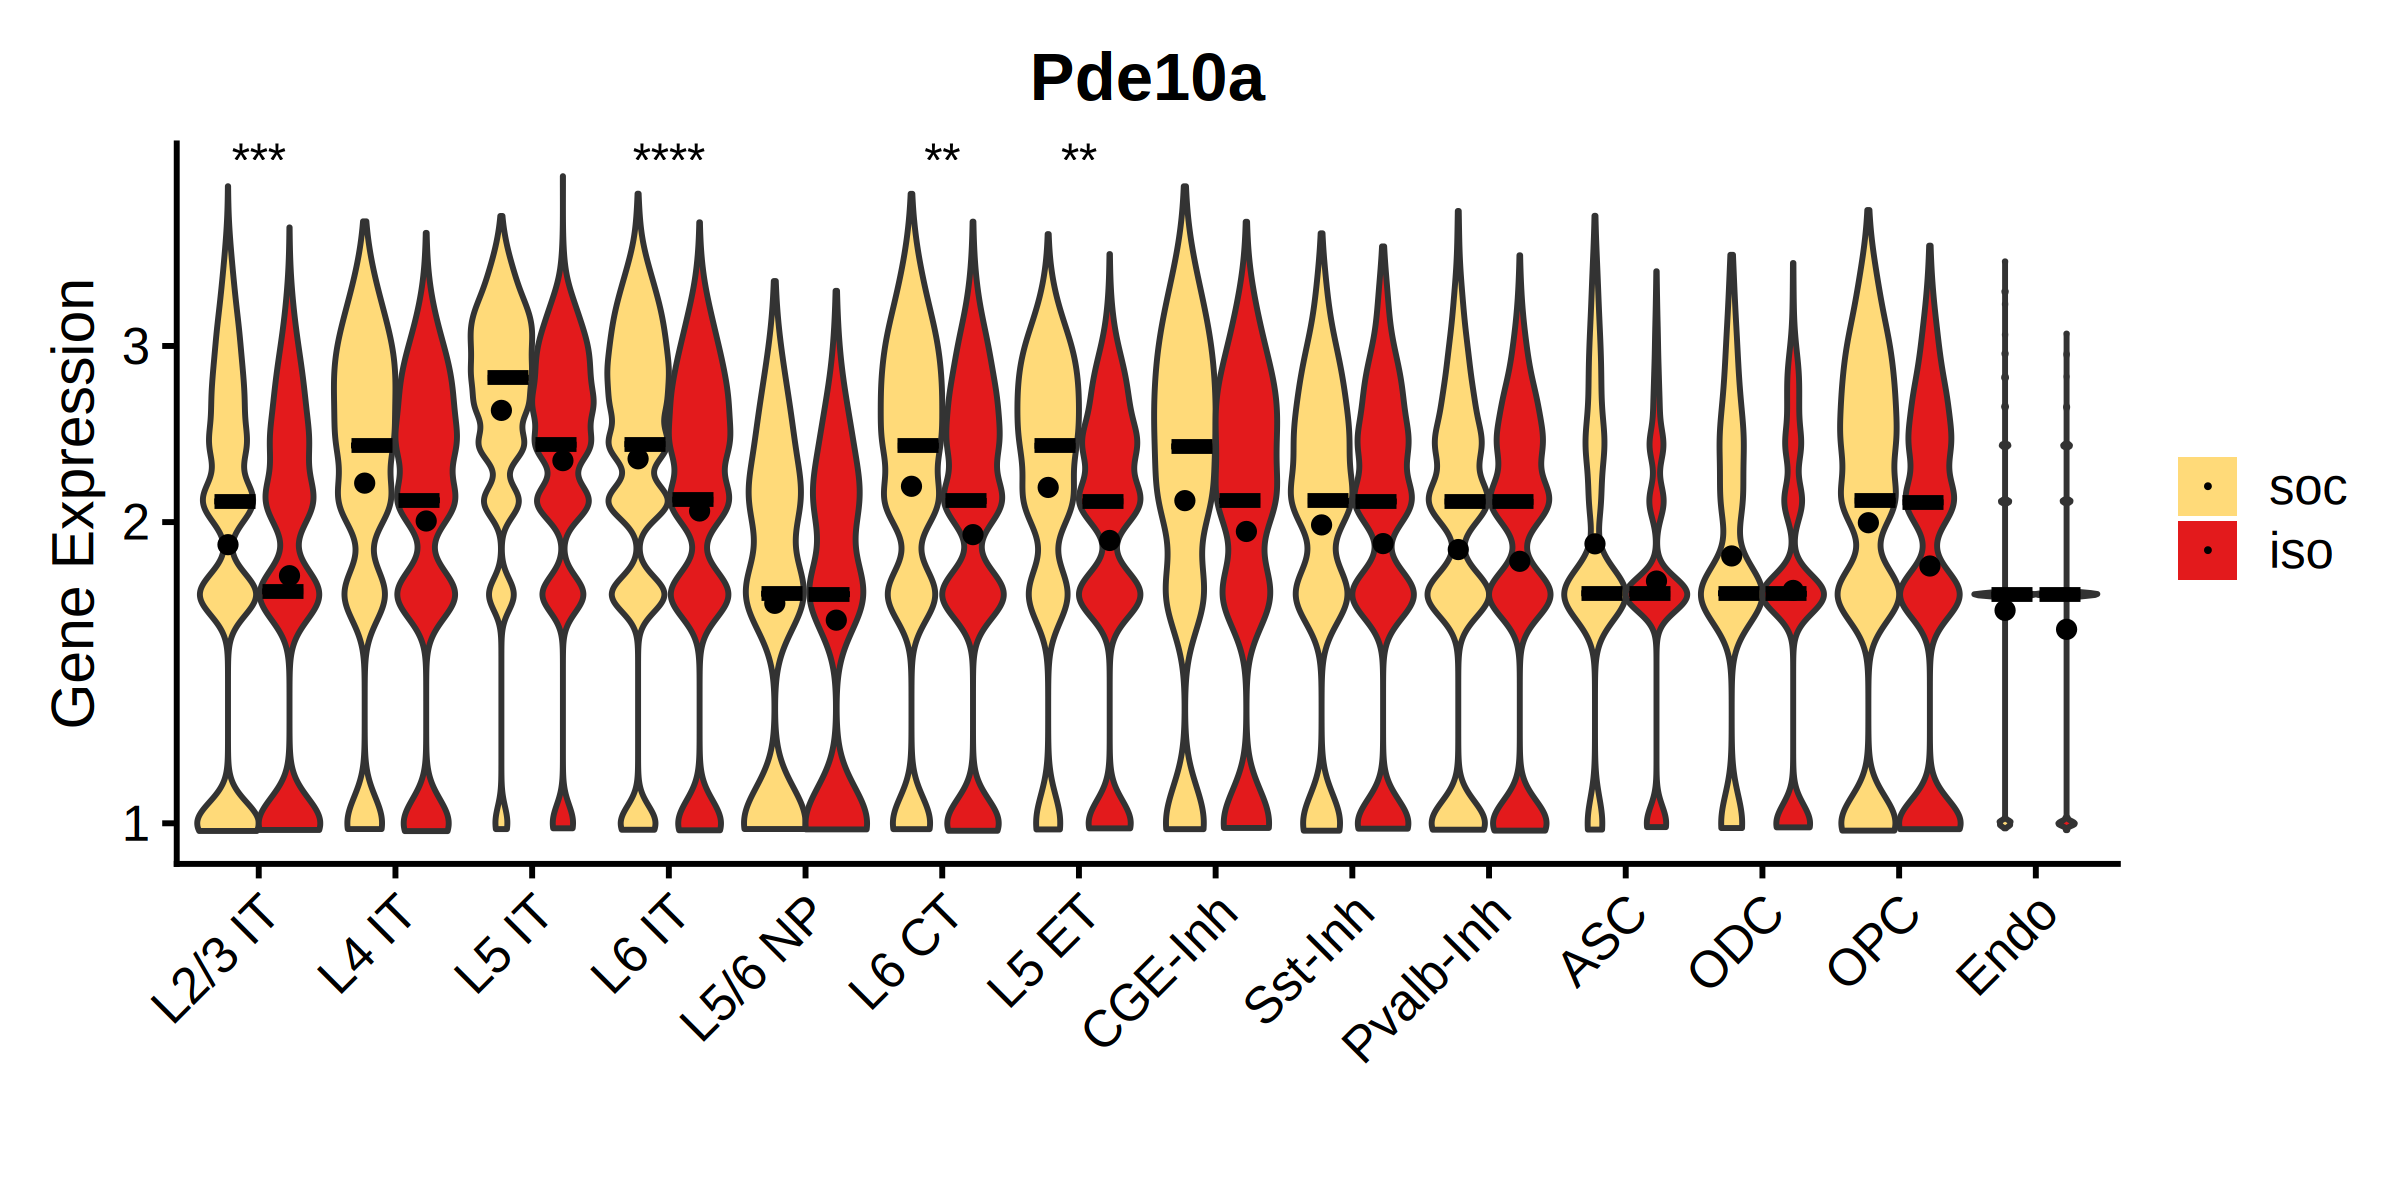

In [72]:
options(repr.plot.width = 8, repr.plot.height = 4, repr.plot.res = 300)
make_vlnplot(genes="Pde10a",
                 celltype=names(pseudo_de),
            label_df=subset(isoVSsoc_DEG_ls,gene=="Pde10a"))

In [ ]:
pdf(file = "./Vlnplot_for_overlapping_DEGs.pdf",width=4,height=4,onefile=TRUE)
for(i in seq_len(nrow(gene_for_plot))){
    p <- make_vlnplot(genes=gene_for_plot[i,"V1"],
                 celltype=unlist(stringr::str_split(gene_for_plot[i,"V2"],",")))
    print(p)
}
dev.off()

In [32]:
seu_obj@meta.data$group <- factor(seu_obj@meta.data$group,levels=c("soc","iso"))

In [ ]:
## make plot for those genes in all celltypes
pdf(file = "./Vlnplot_for_isoVSsoc_DEGs_in_all_celltypes (log=F).pdf",width=8,height=4,onefile=TRUE)
for(i in seq_len(nrow(gene_for_plot))){
    p <- make_vlnplot(genes=gene_for_plot[i,"V1"],
                 celltype=names(pseudo_de),
            label_df=subset(isoVSsoc_DEG_ls,gene==gene_for_plot[i,"V1"]))
    print(p)
}
dev.off()

In [38]:
dev.off()

pdf 
  3

## make umaps for DEGs

In [105]:
my_cols = c("L2/3 IT" = "#D9F0A3",
            "L4 IT" = "#C77963",
            "L5 IT" = "#FDDCFF",
            "L6 IT" = "#B832E5",
            "L5/6 NP" = "#AD6C49",
            "L5 ET" = "#B28D9A",
            "L6 CT" = "#0094C2",
            "CGE-Inh" = "#CEFF00",
            "Sst-Inh" = "#C8C8C8",
            "Pvalb-Inh" = "#0640FF",
            "ASC" = "#00B7FF",
            "ODC" = "#0DFF00",
            "OPC" = "#81AA70",
            "STR" = "#ADBF00",
            "Endo" = "#9E7153")

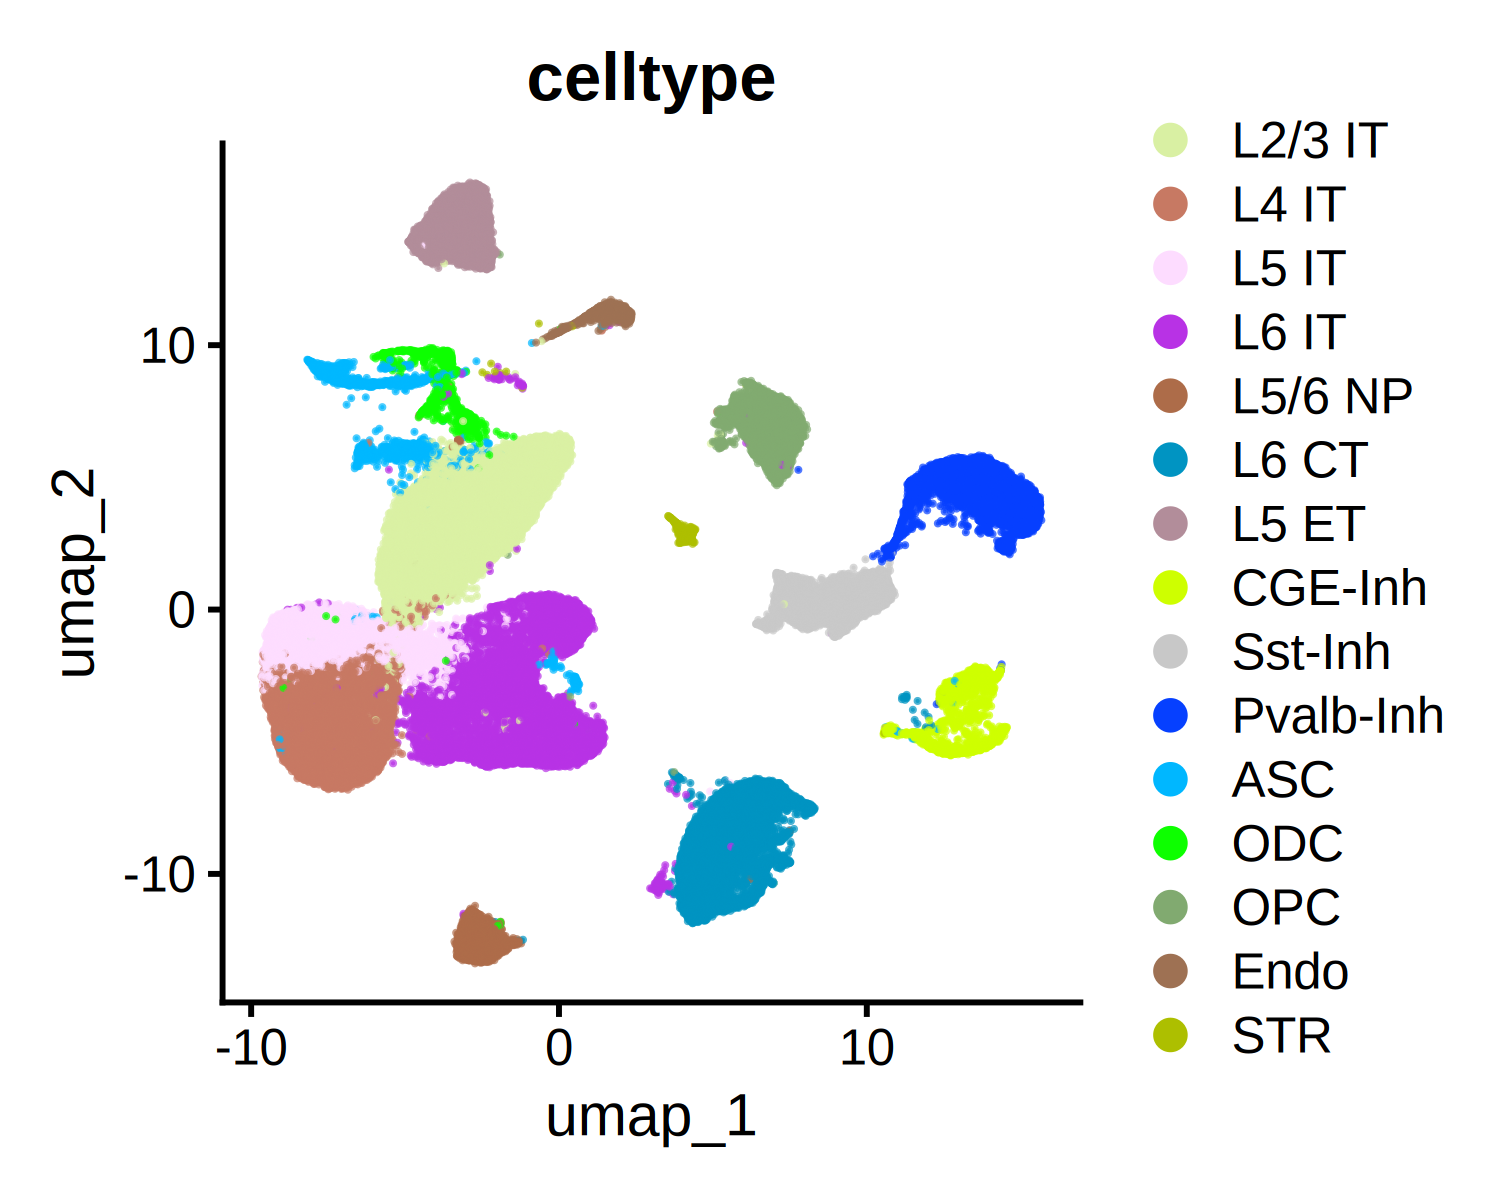

In [106]:
options(repr.plot.width = 5, repr.plot.height = 4, repr.plot.res = 300)
DimPlot(seu_obj, reduction = "umap", group.by = "celltype",alpha=0.7,cols = my_cols)

In [120]:
pdf(file = "./umap_for_overlapping_DEGs.pdf",width=10,height=5,onefile=TRUE)
for(i in seq_len(nrow(gene_for_plot))){
    p <- FeaturePlot(seu_obj, features = gene_for_plot[i,"V1"],split.by="group") + 
            theme(legend.position = c(-0.35,0.2))+
            theme(legend.text=element_text(size=10, color="black"))
    print(p)
}
dev.off()

png 
  2

## make heatmap for DEGs

In [96]:
all_up_gene <- do.call(rbind,Map(cbind, DEG_up_ls, new_clumn = names(DEG_up_ls))) %>%
  mutate(gene = str_split(row.names(.), "\\.", simplify = TRUE)[, 2]) %>%
    filter(gene != "") %>%
    pull(gene) %>%
    unique()

In [100]:
options(repr.plot.width = 7, repr.plot.height = 4, repr.plot.res = 300)
col_anno = data.frame(celltype=pseudo_seu@meta.data$celltype,
                     sex=str_split(pseudo_seu@meta.data$sample_name,"-",simplify = T)[,2],
                      group=str_split(pseudo_seu@meta.data$sample_name,"-",simplify = T)[,1],
                     row.names=row.names(pseudo_seu@meta.data))

column_ha = HeatmapAnnotation(celltype=col_anno$celltype,
                              sex=col_anno$sex,group=col_anno$group,
                             col = list(sex = c("F"="#81b29a","M"="#e07a5f"),
                                       group = c("iso"="#8da9c4","soc"="#f2cc8f"),
                                       celltype = c("L2/3 IT" = "#D9F0A3","L4 IT" = "#C77963","L5 IT" = "#FDDCFF",
                                                   "L6 IT" = "#B832E5","L5/6 NP" = "#AD6C49","L5 ET" = "#B28D9A",
                                                   "L6 CT" = "#0094C2","CGE-Inh" = "#CEFF00","Sst-Inh" = "#C8C8C8",
                                                   "Pvalb-Inh" = "#0640FF","ASC" = "#00B7FF","ODC" = "#0DFF00",
                                                    "OPC" = "#81AA70","Endo" = "#9E7153","STR" = "#ADBF00")))
lgd1 = Legend(title = "group", at = c("iso","soc"), legend_gp = gpar(fill = 1:2))
lgd2 = Legend(title = "sex", at = c("F","M"), legend_gp = gpar(fill = 3:4))

p <- Heatmap(t(scale(t(pseudo_seu@assays$RNA$data[all_up_gene,]))),
        top_annotation = column_ha,
        cluster_rows = FALSE,
        cluster_columns = FALSE,
        row_names_gp = gpar(fontsize = 6),
        column_names_gp = gpar(fontsize = 6),
        column_split = factor(col_anno$celltype,levels=unique(col_anno$celltype)),
        column_title_gp = gpar( fontsize = 5),
        name="expession",
        show_column_names = FALSE        
       )

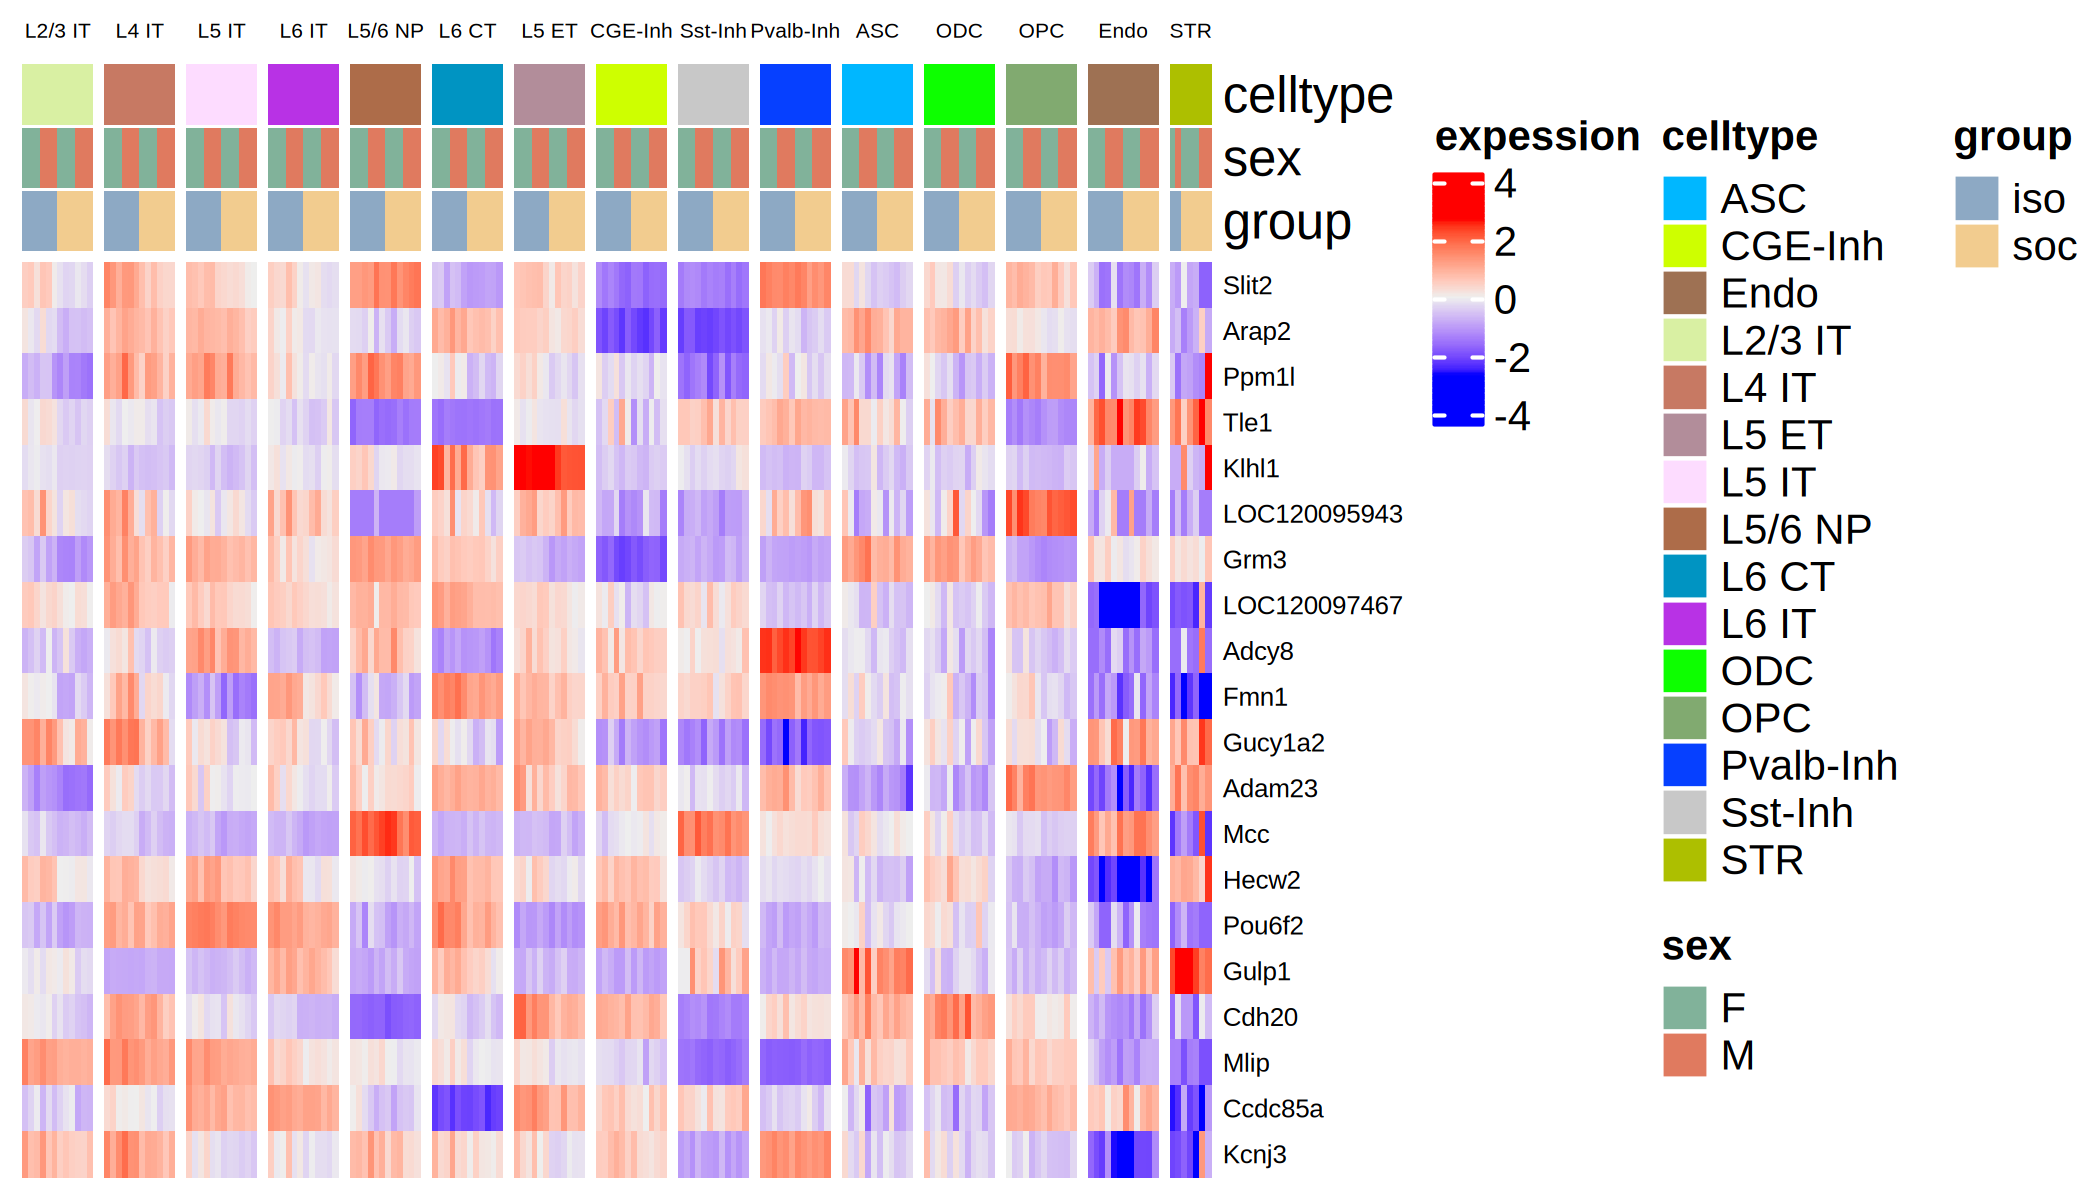

In [101]:
p

In [102]:
all_down_gene <- do.call(rbind,Map(cbind, DEG_down_ls, new_clumn = names(DEG_down_ls))) %>%
  mutate(gene = str_split(row.names(.), "\\.", simplify = TRUE)[, 2]) %>%
    filter(gene != "") %>%
    pull(gene) %>%
    unique()
options(repr.plot.width = 7, repr.plot.height = 4, repr.plot.res = 300)
col_anno = data.frame(celltype=pseudo_seu@meta.data$celltype,
                     sex=str_split(pseudo_seu@meta.data$sample_name,"-",simplify = T)[,2],
                      group=str_split(pseudo_seu@meta.data$sample_name,"-",simplify = T)[,1],
                     row.names=row.names(pseudo_seu@meta.data))

column_ha = HeatmapAnnotation(celltype=col_anno$celltype,
                              sex=col_anno$sex,group=col_anno$group,
                             col = list(sex = c("F"="#81b29a","M"="#e07a5f"),
                                       group = c("iso"="#8da9c4","soc"="#f2cc8f"),
                                       celltype = c("L2/3 IT" = "#D9F0A3","L4 IT" = "#C77963","L5 IT" = "#FDDCFF",
                                                   "L6 IT" = "#B832E5","L5/6 NP" = "#AD6C49","L5 ET" = "#B28D9A",
                                                   "L6 CT" = "#0094C2","CGE-Inh" = "#CEFF00","Sst-Inh" = "#C8C8C8",
                                                   "Pvalb-Inh" = "#0640FF","ASC" = "#00B7FF","Oligo" = "#21F4CC",
                                                   "ODC" = "#0DFF00","OPC" = "#81AA70","STR" = "#ADBF00","Endo" = "#9E7153")))
lgd1 = Legend(title = "group", at = c("iso","soc"), legend_gp = gpar(fill = 1:2))
lgd2 = Legend(title = "sex", at = c("F","M"), legend_gp = gpar(fill = 3:4))

p<- Heatmap(t(scale(t(pseudo_seu@assays$RNA$data[all_down_gene,]))),
        top_annotation = column_ha,
        cluster_rows = FALSE,
        cluster_columns = FALSE,
        row_names_gp = gpar(fontsize = 6),
        column_names_gp = gpar(fontsize = 6),
        column_split = factor(col_anno$celltype,levels=unique(col_anno$celltype)),
        column_title_gp = gpar( fontsize = 5),
        name="expession",
        show_column_names = FALSE        
       )

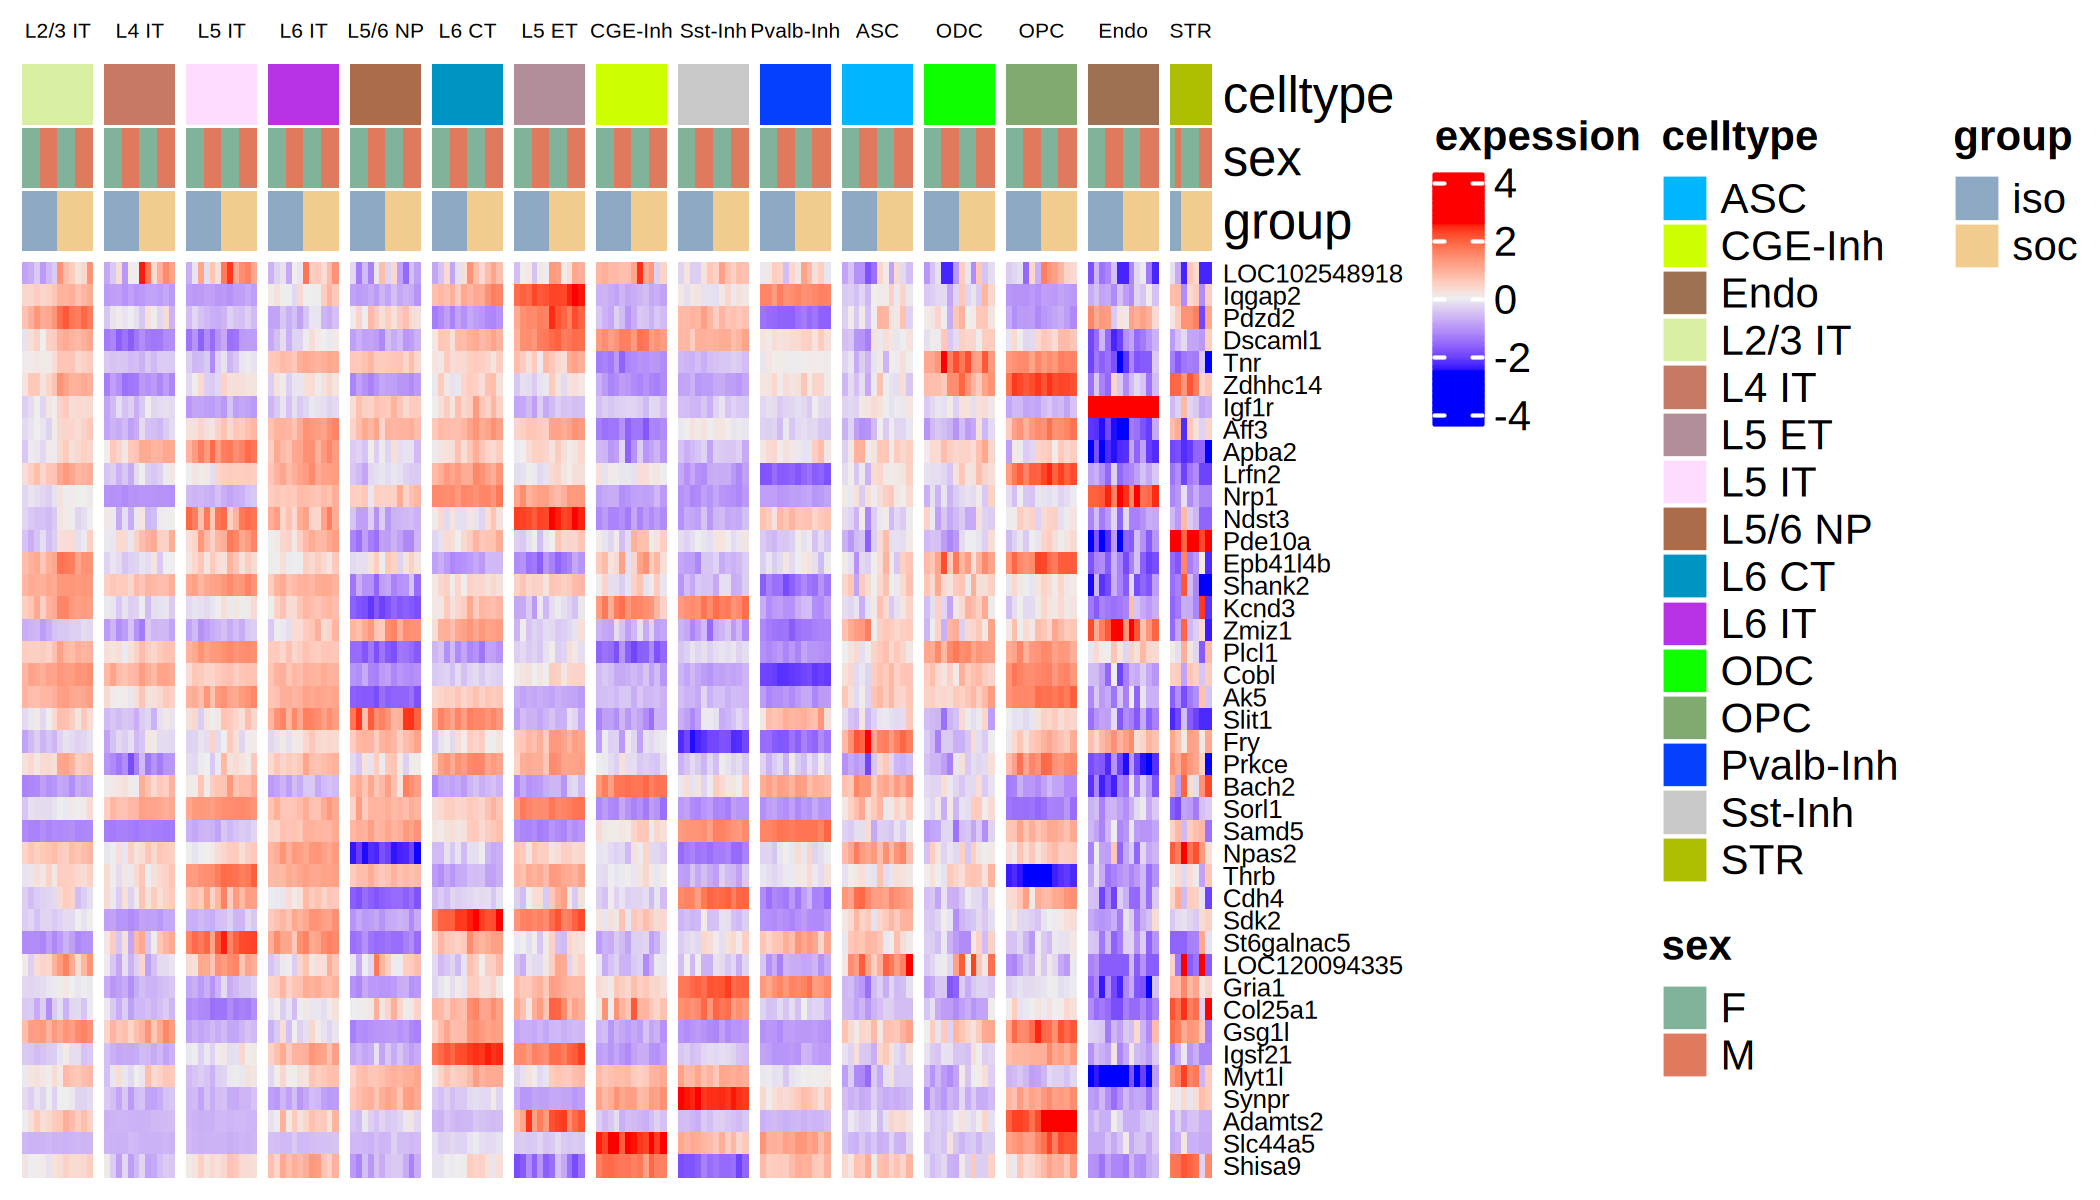

In [103]:
p

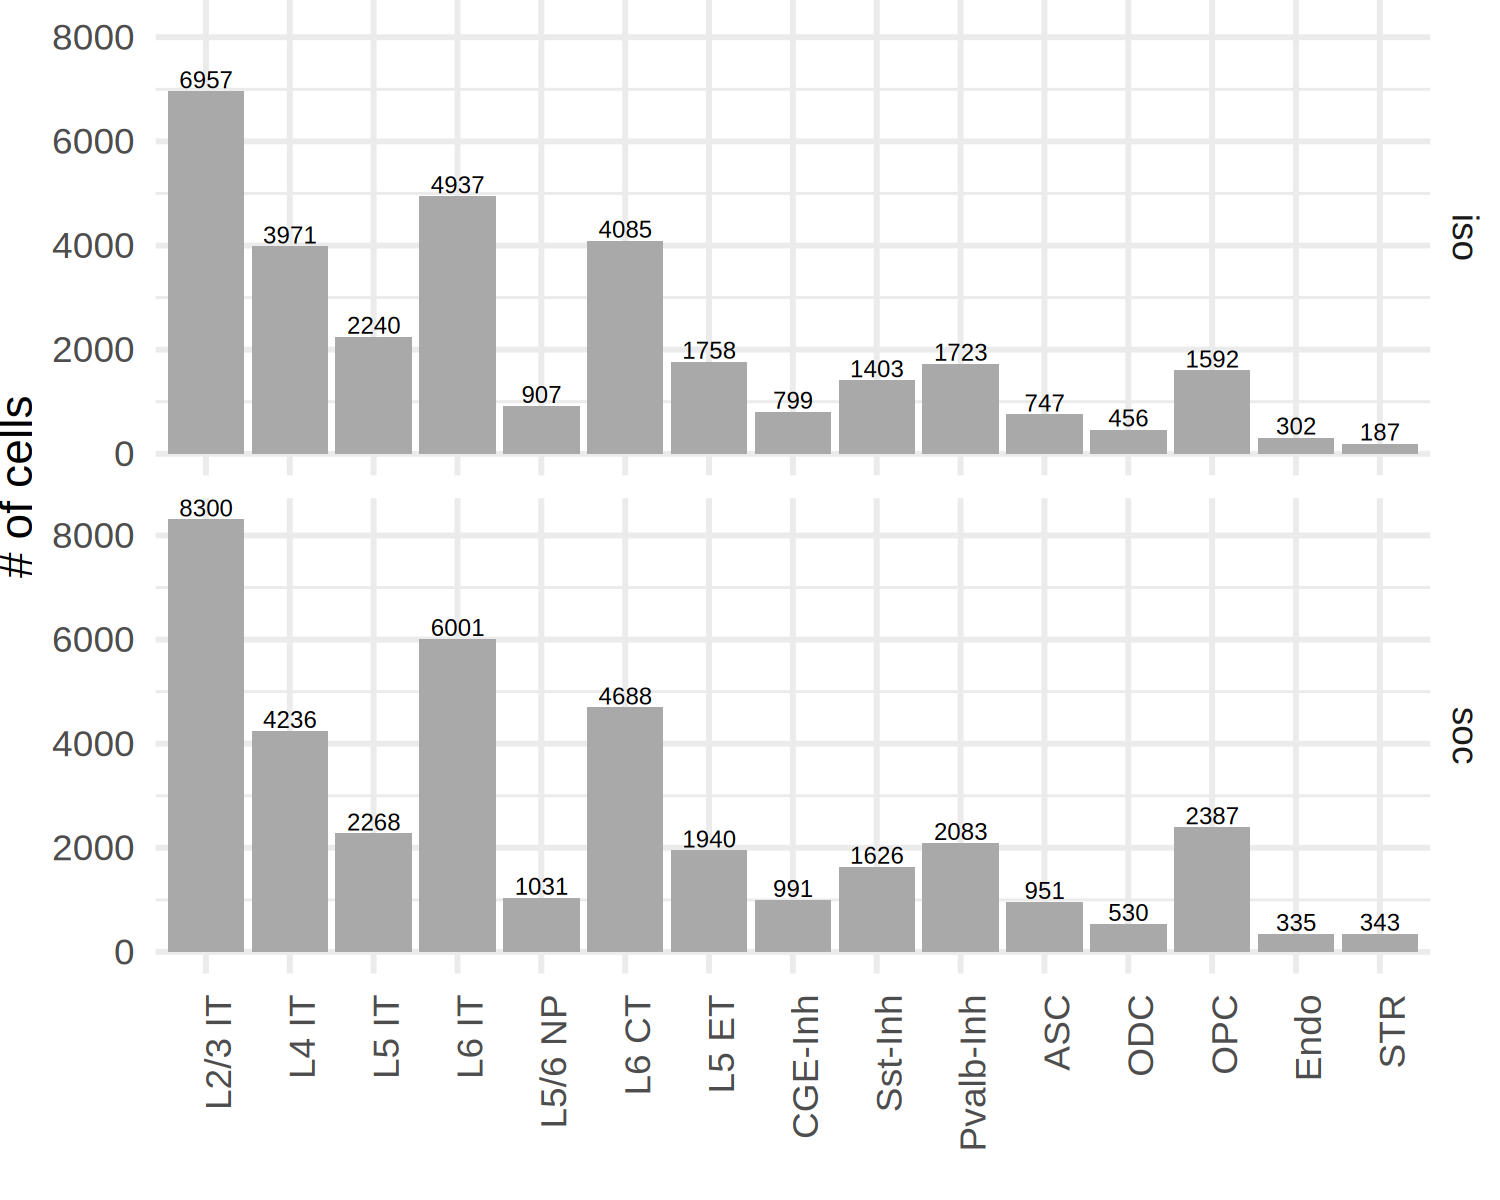

In [104]:
options(repr.plot.width = 5, repr.plot.height = 4, repr.plot.res = 300)
seu_obj@meta.data %>%
    #count(celltype) %>%
    filter(celltype!="NA") %>%
    ggplot(aes(x=celltype))+
    geom_bar(fill="darkgrey")+
    geom_text(stat='count', aes(label=..count..), vjust=-0.2,size=2)+
    #geom_text(aes(label = n), vjust = 0.5,size=2)+
    facet_grid(group~.)+
    labs(x="",y="# of cells")+
    theme_minimal()+
    theme(axis.text.x=element_text(angle=90,hjust=1),
         plot.margin = unit(c(0,0,0,0), "cm"))

## GO analysis for DEGs

In [ ]:
library(stringr)
library(viridis)
library(org.Rn.eg.db)
library(clusterProfiler)
library(openxlsx)

In [129]:
dir.create("./isoVSsoc_DEG_GO_2")

In [ ]:
DEG_ls <- lapply(pseudo_de, function(x){ x %>% filter(p_val_adj<0.05,abs(avg_log2FC) >0.3) %>% row.names()})
names(DEG_ls) = str_replace_all(string =names(DEG_ls) ,pattern = "\\/" ,replacement = "")
GO_ls <- list()
for(i in seq_len(length(DEG_ls))){
    if(length(DEG_ls[[i]])>5){
           go_res <- enrichGO(DEG_ls[[i]],OrgDb=org.Rn.eg.db,keyType="SYMBOL",ont="BP",pvalueCutoff  = 0.05, qvalueCutoff  = 1)
          if(!is.null(go_res@result)){
              GO_ls[names(DEG_ls)[i]] <- go_res
          }
           }
}
cp_GO_ls <- GO_ls

write.xlsx(lapply(cp_GO_ls,function(df){df@result}),file="./isoVSsoc_DEG_GO_2/isoVSsoc_DEG_FC0.3_GO.xlsx",asTable=T)


In [ ]:
pdf("/project/zhuzhuzhang/lyang/scaleBio_RNA_rat_brain/out_mRatBN/isoVSsoc_DEG_GO_2/isoVSsoc_DEG_FC0.3_GO_dotplot.pdf",onefile=TRUE)
lapply(seq_along(GO_ls),
       function(i){
           if(!is.null(GO_ls[[i]])){
           if(dim(GO_ls[[i]]@result)[1]>0){
               if(sum(GO_ls[[i]]@result$p.adjust<0.05)>0){
                   GO_ls[[i]]@result %>%
                   filter(p.adjust<0.05) %>%
                       mutate(ratio=as.numeric(str_split(GeneRatio,"/",simplify=T)[,1])/as.numeric(str_split(GeneRatio,"/",simplify=T)[,2])) %>%
                       slice_head(n=15) %>%
                        arrange(ratio) %>%
                        mutate(Description=factor(Description,levels=Description)) %>%
                       ggplot(aes(x=ratio,y=Description))+
                       geom_point(aes(color=p.adjust,size=ratio))+
                       labs(title=paste0(names(GO_ls)[i]," ","iso vs soc ","(",length(DEG_ls[[i]]) ,")"))+
                       scale_y_discrete(labels = function(x) str_wrap(x, width = 50))+
                        scale_color_viridis(option = "D")
                   }
               
           }
            }
           }
)
dev.off()